## Read ReadMe for instructions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgboost
import re
pd.set_option('display.max_columns', None)

In [2]:
accepted_df = pd.read_csv("datasets/accepted_dataset.csv")
rejected_df = pd.read_csv("datasets/rejected_dataset.csv")

C:\Users\mtkub\AppData\Local\Temp\ipykernel_18196\3125798192.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_df = pd.read_csv("datasets/accepted_dataset.csv")


In [3]:
accepted_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

In [4]:
rejected_df.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0.0


In [5]:
np.array(accepted_df.keys())

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'po

In [6]:
np.array(rejected_df.keys())

array(['Amount Requested', 'Application Date', 'Loan Title', 'Risk_Score',
       'Debt-To-Income Ratio', 'Zip Code', 'State', 'Employment Length',
       'Policy Code'], dtype=object)

In [7]:
np.intersect1d(np.array(accepted_df.keys()), np.array(rejected_df.keys()))

array([], dtype=object)

## Formatting

In [8]:
import pandas as pd
import numpy as np
import re 

CORE_FEATURES = [
    'loan_amnt',
    'dti',
    'addr_state',
    'emp_length',
    'purpose',
    'fico_score',       # Standardized FICO/Risk Score
    'application_date', # Standardized date
    'status'            # Target variable (1=Accepted, 0=Rejected)
]

# --- Preprocessing Functions ---

def clean_emp_length(emp_length_str):
    """Cleans the employment length string into numeric years."""
    if pd.isna(emp_length_str) or emp_length_str in ['n/a', 'nan']:
        return np.nan # Use NaN to represent missing/not applicable
    elif emp_length_str == '< 1 year':
        return 0
    elif '10+ years' in emp_length_str:
        return 10
    else:
        # Extract numbers using regex
        match = re.search(r'\d+', emp_length_str)
        if match:
            return int(match.group(0))
        else:
            return np.nan # Cannot parse


# --- Step 1: Add Target Status ---
accepted_df['status'] = 1
rejected_df['status'] = 0

# --- Step 2 & 3: Rename and Select Columns (Rejected) ---
print("Preprocessing Rejected Loans...")
# Rename columns in rejected_df to match accepted_df conventions
rename_map_rejected = {
    'Amount Requested': 'loan_amnt',
    'Application Date': 'application_date_str', # Keep temporary string name
    'Loan Title': 'purpose',
    'Risk_Score': 'fico_score',          # Assuming Risk_Score maps to FICO
    'Debt-To-Income Ratio': 'dti_str',  # Keep temporary string name
    'State': 'addr_state',
    'Employment Length': 'emp_length_str', # Keep temporary string name
    # Add 'Zip Code': 'zip_code' if needed
    # Add 'Policy Code': 'policy_code' if needed
}
# Select only the columns we intend to map plus the status
cols_to_keep_rejected = list(rename_map_rejected.keys()) + ['status']
rejected_df_processed = rejected_df[cols_to_keep_rejected].copy()
rejected_df_processed.rename(columns=rename_map_rejected, inplace=True)
rejected_df_processed = rejected_df_processed.sort_index(axis=1)

print("Preprocessing Accepted Loans...")
# Select corresponding columns plus the status
# We need 'issue_d' for date, 'fico_range_low' for score, raw 'dti', raw 'emp_length'
cols_to_keep_accepted = [
    'loan_amnt',
    'issue_d',          # Use as proxy for application date
    'purpose',
    'dti',              # Raw DTI
    'addr_state',
    'emp_length',       # Raw emp_length
    'fico_range_low',   # Use low end of FICO range
    'status'
    # Add 'zip_code' if needed
    # Add 'policy_code' if needed
]
# Filter out potential columns not present in older datasets if necessary
available_cols_accepted = [col for col in cols_to_keep_accepted if col in accepted_df.columns]
accepted_df_processed = accepted_df[available_cols_accepted].copy()

# Rename accepted columns to standardized names
accepted_df_processed.rename(columns={
    'issue_d': 'application_date_str',
    'fico_range_low': 'fico_score',
    'emp_length': 'emp_length_str', # Keep temp name before cleaning
    'dti': 'dti_str'             # Keep temp name before cleaning
}, inplace=True)

accepted_df_processed = accepted_df_processed.sort_index(axis=1)

print("Standardizing data types...")
accepted_df_processed['application_date_str'] = pd.to_datetime(accepted_df_processed['application_date_str'], format='%b-%Y').dt.strftime('%Y-%m-%d')
accepted_df_processed['application_date_str'] = pd.to_datetime(accepted_df_processed['application_date_str'], errors='coerce')
rejected_df_processed['application_date_str'] = pd.to_datetime(rejected_df_processed['application_date_str'], errors='coerce')
rejected_df_processed['dti_str'] = rejected_df_processed['dti_str'].str.replace('%', '').astype(float)
emp_length_mapping = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

accepted_df_processed['emp_length_str'] = accepted_df_processed['emp_length_str'].map(emp_length_mapping)
rejected_df_processed['emp_length_str'] = rejected_df_processed['emp_length_str'].map(emp_length_mapping)
accepted_df_processed['emp_length_str'] = accepted_df_processed['emp_length_str'].astype(float)
rejected_df_processed['emp_length_str'] = rejected_df_processed['emp_length_str'].astype(float)
accepted_df_processed['purpose'] = accepted_df_processed['purpose'].str.replace('_', ' ')
rejected_df_processed['purpose'] = rejected_df_processed['purpose'].str.lower()

accepted_final = accepted_df_processed.copy()
rejected_final = rejected_df_processed.copy()

Preprocessing Rejected Loans...
Preprocessing Accepted Loans...
Standardizing data types...


In [9]:
display(accepted_final.head())
display(rejected_final.head())
display(accepted_final.dtypes)
display(rejected_final.dtypes)

,addr_state,application_date_str,dti_str,emp_length_str,fico_score,loan_amnt,purpose,status
0,PA,2015-12-01,5.91,10.0,675.0,3600.0,debt consolidation,1
1,SD,2015-12-01,16.06,10.0,715.0,24700.0,small business,1
2,IL,2015-12-01,10.78,10.0,695.0,20000.0,home improvement,1
3,NJ,2015-12-01,17.06,10.0,785.0,35000.0,debt consolidation,1
4,PA,2015-12-01,25.37,3.0,695.0,10400.0,major purchase,1


,addr_state,application_date_str,dti_str,emp_length_str,fico_score,loan_amnt,purpose,status
0,NM,2007-05-26,10.00,4.0,693.0,1000.0,wedding covered but no honeymoon,0
1,MA,2007-05-26,10.00,0.0,703.0,1000.0,consolidating debt,0
2,MD,2007-05-27,10.00,1.0,715.0,11000.0,want to consolidate my debt,0
3,MA,2007-05-27,38.64,0.0,698.0,6000.0,waksman,0
4,MD,2007-05-27,9.43,0.0,509.0,1500.0,mdrigo,0


addr_state                      object
application_date_str    datetime64[ns]
dti_str                        float64
emp_length_str                 float64
fico_score                     float64
loan_amnt                      float64
purpose                         object
status                           int64
dtype: object

addr_state                      object
application_date_str    datetime64[ns]
dti_str                        float64
emp_length_str                 float64
fico_score                     float64
loan_amnt                      float64
purpose                         object
status                           int64
dtype: object

In [10]:
# --- Step 6: Combine DataFrames ---
print("Combining datasets...")
combined_df = pd.concat([accepted_final, rejected_final], ignore_index=True)
print(f"Combined dataset shape: {combined_df.shape}")

print("Renaming columns...")
combined_df = combined_df.rename(columns={'application_date_str': 'application_date', 'emp_length_str':'emp_length', 'dti_str':'dti'})

# Drop rows where the application date is missing, as it's crucial for temporal split
combined_df.dropna(subset=['application_date'], inplace=True)
print(f"Shape after dropping rows with missing application date: {combined_df.shape}")
display(combined_df.head())

# --- Step 7: Handle Missing Values ---
print("Handling missing values...")
print("Missing values before imputation:")
print(combined_df.isnull().sum())
print("Dropping null:")
combined_df = combined_df.dropna()
print(combined_df.isnull().sum())
print("Updated split:")
display(combined_df['status'].value_counts())

Combining datasets...
Combined dataset shape: (29909442, 8)
Renaming columns...
Shape after dropping rows with missing application date: (29909409, 8)


,addr_state,application_date,dti,emp_length,fico_score,loan_amnt,purpose,status
0,PA,2015-12-01,5.91,10.0,675.0,3600.0,debt consolidation,1
1,SD,2015-12-01,16.06,10.0,715.0,24700.0,small business,1
2,IL,2015-12-01,10.78,10.0,695.0,20000.0,home improvement,1
3,NJ,2015-12-01,17.06,10.0,785.0,35000.0,debt consolidation,1
4,PA,2015-12-01,25.37,3.0,695.0,10400.0,major purchase,1


Handling missing values...
Missing values before imputation:
addr_state                22
application_date           0
dti                     1711
emp_length           1098262
fico_score          18497630
loan_amnt                  0
purpose                 1305
status                     0
dtype: int64
Dropping null:
addr_state          0
application_date    0
dti                 0
emp_length          0
fico_score          0
loan_amnt           0
purpose             0
status              0
dtype: int64
Updated split:


status
0    8992564
1    2113648
Name: count, dtype: int64

In [11]:
# --- Step 9: Extract Year and Temporal Split ---
print("Splitting data by time period...")
combined_df['year'] = combined_df['application_date'].dt.year

# Define time periods
recession_years = range(2007, 2013) # 2007-2012 inclusive
post_recession_years = range(2013, 2019) # 2013-2018 inclusive

recession_df = combined_df[combined_df['year'].isin(recession_years)].copy()
post_recession_df = combined_df[combined_df['year'].isin(post_recession_years)].copy()

# Drop the date and year columns as they are no longer needed for modeling itself
recession_df.drop(columns=['application_date', 'year'], inplace=True)
post_recession_df.drop(columns=['application_date', 'year'], inplace=True)

print(f"Recession Era (2007-2012) dataset shape: {recession_df.shape}")
print(f"Post-Recession Era (2013-2018) dataset shape: {post_recession_df.shape}")

# --- Final Check ---
print("\nPreprocessing Complete.")
print("\nRecession Data Info:")
recession_df.info()
print("\nPost-Recession Data Info:")
post_recession_df.info()

Splitting data by time period...
Recession Era (2007-2012) dataset shape: (816388, 7)
Post-Recession Era (2013-2018) dataset shape: (10289824, 7)

Preprocessing Complete.

Recession Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 816388 entries, 1611879 to 3016191
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   addr_state  816388 non-null  object 
 1   dti         816388 non-null  float64
 2   emp_length  816388 non-null  float64
 3   fico_score  816388 non-null  float64
 4   loan_amnt   816388 non-null  float64
 5   purpose     816388 non-null  object 
 6   status      816388 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 49.8+ MB

Post-Recession Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 10289824 entries, 0 to 29909441
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   addr_state  object 
 1   dti         float64
 2   emp_length  f

In [12]:
recession_df.dtypes

addr_state     object
dti           float64
emp_length    float64
fico_score    float64
loan_amnt     float64
purpose        object
status          int64
dtype: object

In [13]:
recession_df.head()

,addr_state,dti,emp_length,fico_score,loan_amnt,purpose,status
1611879,AZ,27.65,10.0,735.0,5000.0,credit card,1
1611880,GA,1.00,0.0,740.0,2500.0,car,1
1611881,IL,8.72,10.0,735.0,2400.0,small business,1
1611882,CA,20.00,10.0,690.0,10000.0,other,1
1611883,OR,17.94,1.0,695.0,3000.0,other,1


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Prepare the data
def prepare_data(df):
    # Encode categorical variables
    le = LabelEncoder()
    df['addr_state'] = le.fit_transform(df['addr_state'])
    df['purpose'] = le.fit_transform(df['purpose'])
    
    # Split features and target
    X = df.drop('status', axis=1)
    y = df['status']
    return X, y

# Train model for recession period
X_recession, y_recession = prepare_data(recession_df)
X_train, X_test, y_train, y_test = train_test_split(X_recession, y_recession, test_size=0.2, random_state=42)

# Initialize and train XGBoost
log_model = LogisticRegression(
    random_state=42
)

log_model.fit(X_train, y_train)

# Make predictions
y_pred = log_model.predict(X_test)

# Print results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8818701845931479

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94    144688
           1       0.46      0.24      0.31     18590

    accuracy                           0.88    163278
   macro avg       0.69      0.60      0.62    163278
weighted avg       0.86      0.88      0.86    163278



C:\Users\mtkub\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\Users\mtkub\AppData\Local\Temp\ipykernel_18196\225723123.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(pos, importances[sorted_idx], align='center')


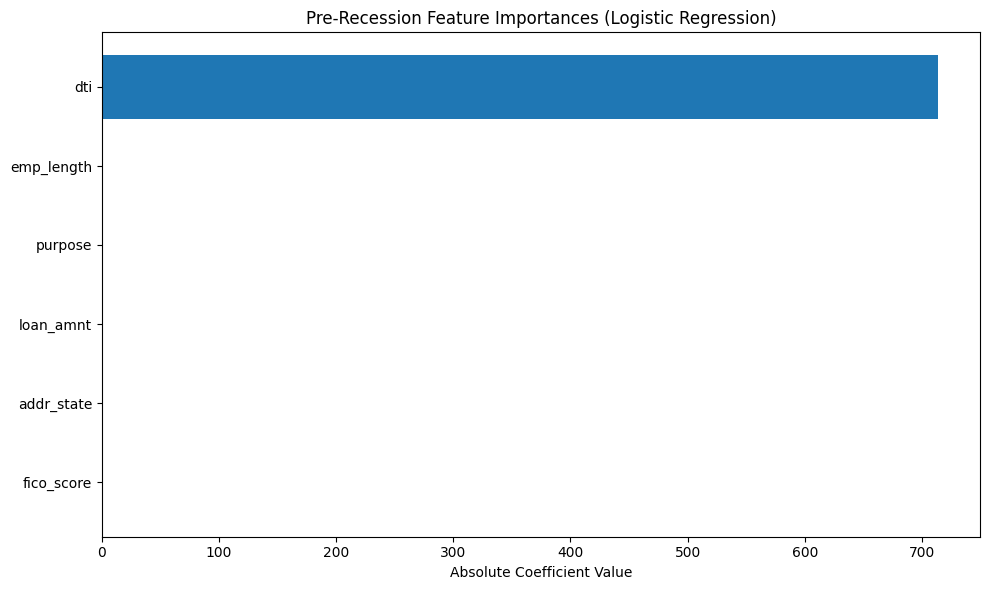

In [41]:
# Standardize coefficients by multiplying by feature std dev
std_coef = log_model.coef_[0] * np.std(X_train, axis=0)
importances = np.abs(std_coef)

feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

# Sort features by importance
sorted_idx = np.argsort(importances)
pos = np.arange(sorted_idx.shape[0]) + 0.5

# Plot
plt.figure(figsize=(10, 6))
plt.barh(pos, importances[sorted_idx], align='center')
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title('Pre-Recession Feature Importances (Logistic Regression)')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

In [42]:
#Analyzing of post recession too 
X_recession, y_recession = prepare_data(post_recession_df)
X_train, X_test, y_train, y_test = train_test_split(X_recession, y_recession, test_size=0.2, random_state=42)

# Initialize and train XGBoost
post_log_model = LogisticRegression(
    random_state=42
)

post_log_model.fit(X_train, y_train)

# Make predictions
y_pred = post_log_model.predict(X_test)

# Print results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

C:\Users\mtkub\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8844936624286613

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93   1653266
           1       0.78      0.58      0.66    404699

    accuracy                           0.88   2057965
   macro avg       0.84      0.77      0.80   2057965
weighted avg       0.88      0.88      0.88   2057965



C:\Users\mtkub\AppData\Local\Temp\ipykernel_18196\75950085.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(pos, importances[sorted_idx], align='center')


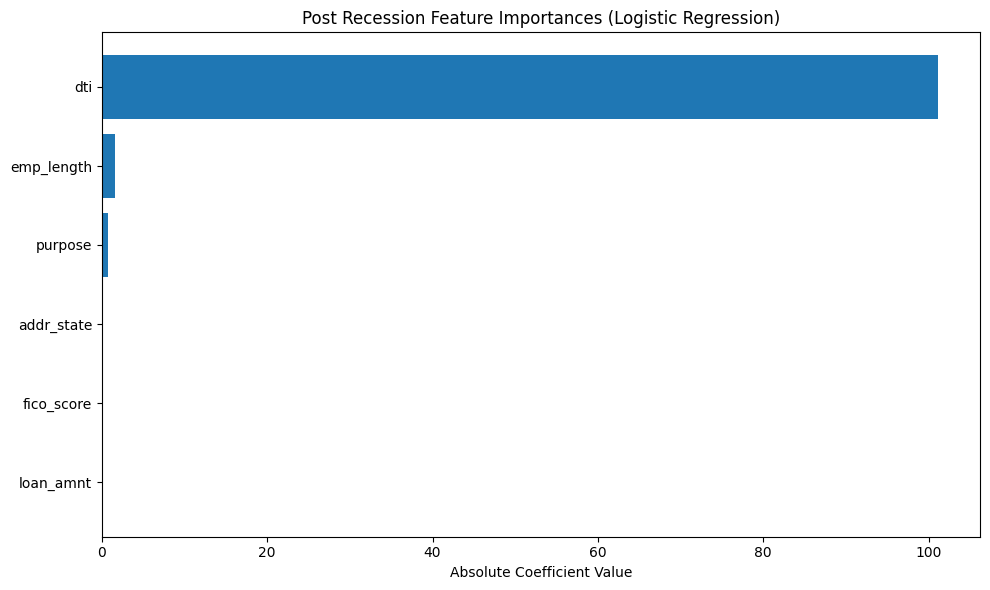

In [43]:
std_coef = post_log_model.coef_[0] * np.std(X_train, axis=0)
importances = np.abs(std_coef)

feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(X_train.shape[1])]

# Sort features by importance
sorted_idx = np.argsort(importances)
pos = np.arange(sorted_idx.shape[0]) + 0.5

# Plot
plt.figure(figsize=(10, 6))
plt.barh(pos, importances[sorted_idx], align='center')
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title('Post Recession Feature Importances (Logistic Regression)')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()